In [1]:
# install for AWS
!pip install torch --quiet
!pip install matplotlib --quiet
!pip install torchvision --quiet
!pip install s3fs --quiet
!pip install boto3 --quiet
!pip install fiftyone --quiet
!pip install pandas --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.28.68 requires botocore<1.32.0,>=1.31.68, but you have botocore 1.31.64 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.31.75 which is incompatible.


In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader
import json
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34
import numpy as np
import boto3
import s3fs
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import defaultdict

import fiftyone.utils.torch as fout
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import fiftyone.core.expressions as foe

from models_package import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# ########## LM ##########

# access_key = getpass.getpass("Enter your access: ")

# secret_key = password = getpass.getpass("Enter your secret: ")

# bucket_name = 'w210facetdata'
# annotations_prefix = 'annotations/'
# images_prefix = '/home/ubuntu/W210-Capstone'

# s3 = s3fs.S3FileSystem(key=access_key, secret=secret_key)

# # Use s3.open to open the CSV file and read its content into a Pandas DataFrame
# with s3.open(f's3://{bucket_name}/{annotations_prefix}annotations.csv', 'rb') as file:
#     gt_df = pd.read_csv(file)



In [4]:
# ########## LM ##########

# # use relative paths to your image dirs
# dataset = fo.Dataset(name = "IDP", persistent=True)
# # dataset = fo.load_dataset('IDP')
# dataset.add_images_dir(images_prefix)
# dataset.compute_metadata()

In [5]:
########## KH ##########

# Initialize S3 client
s3_client = boto3.client('s3', region_name='us-west-2')

# Define the S3 bucket name and prefixes
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

# Load CSV annotations from S3
annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}'
gt_df = pd.read_csv(f'{annotations_s3_path}annotations.csv')

In [6]:
# ########## KH ##########

# UNCOMMENT THIS BLOCK TO PULL FACET DATA FROM S3

# local_images_dir = 'local_images_dir'
# os.makedirs(local_images_dir, exist_ok=True)

# # Create a paginator to handle pagination of the results
# paginator = s3_client.get_paginator('list_objects_v2')

# # Use the paginator to retrieve all objects
# for page in paginator.paginate(Bucket=bucket_name, Prefix=images_prefix):
#     for obj in page.get('Contents', []):
#         # Skip the prefix itself
#         if obj['Key'] == images_prefix:
#             continue
#         local_file_path = os.path.join(local_images_dir, os.path.basename(obj['Key']))
#         s3_client.download_file(bucket_name, obj['Key'], local_file_path)


In [7]:
########## KH ##########
local_images_dir = 'local_images_dir'
fo.delete_dataset('local_images_dir')
dataset = fo.Dataset(name='local_images_dir', persistent=True)
dataset.add_images_dir(local_images_dir)
dataset.compute_metadata()

 100% |█████████████| 31703/31703 [4.9s elapsed, 0s remaining, 6.2K samples/s]      
Computing metadata...
 100% |█████████████| 31703/31703 [1.0m elapsed, 0s remaining, 591.5 samples/s]       


In [8]:
# Count the number of files in the local_images_dir
num_files = len([f for f in os.listdir(local_images_dir) if os.path.isfile(os.path.join(local_images_dir, f))])
print(num_files)

31702


# Object Detection Functions

In [9]:
BOOLEAN_PERSONAL_ATTRS = (
    "has_facial_hair",
    "has_tattoo",
    "has_cap",
    "has_mask",
    "has_headscarf",
    "has_eyeware",
)
def add_boolean_person_attributes(detection, row_index):
    for attr in BOOLEAN_PERSONAL_ATTRS:
        detection[attr] = gt_df.loc[row_index, attr].astype(bool)

In [10]:
def get_hairtype(row_index):
    hair_info = gt_df.loc[row_index, gt_df.columns.str.startswith('hairtype')]
    hairtype = hair_info[hair_info == 1]
    if len(hairtype) == 0:
        return None
    return hairtype.index[0].split('_')[1]

def get_haircolor(row_index):
    hair_info = gt_df.loc[row_index, gt_df.columns.str.startswith('hair_color')]
    haircolor = hair_info[hair_info == 1]
    if len(haircolor) == 0:
        return None
    return haircolor.index[0].split('_')[2]

In [11]:
def add_person_attributes(detection, row_index):
    detection["hairtype"] = get_hairtype(row_index)
    detection["haircolor"] = get_haircolor(row_index)
    add_boolean_person_attributes(detection, row_index)

In [12]:
def get_perceived_gender_presentation(row_index):
    gender_info = gt_df.loc[row_index, gt_df.columns.str.startswith('gender')]
    pgp = gender_info[gender_info == 1]
    if len(pgp) == 0:
        return None
    return pgp.index[0].replace("gender_presentation_", "").replace("_", " ")

def get_perceived_age_presentation(row_index):
    age_info = gt_df.loc[row_index, gt_df.columns.str.startswith('age')]
    pap = age_info[age_info == 1]
    if len(pap) == 0:
        return None
    return pap.index[0].split('_')[2]

In [13]:
def get_skintone(row_index):
    skin_info = gt_df.loc[row_index, gt_df.columns.str.startswith('skin_tone')]
    return skin_info.to_dict()

In [14]:
def add_protected_attributes(detection, row_index):
    detection["perceived_age_presentation"] = get_perceived_age_presentation(row_index)
    detection["perceived_gender_presentation"] = get_perceived_gender_presentation(row_index)
    detection["skin_tone"] = get_skintone(row_index)

In [15]:
VISIBILITY_ATTRS = ("visible_torso", "visible_face", "visible_minimal")

In [16]:
def get_lighting(row_index):
    lighting_info = gt_df.loc[row_index, gt_df.columns.str.startswith('lighting')]
    lighting = lighting_info[lighting_info == 1]
    if len(lighting) == 0:
        return None
    lighting = lighting.index[0].replace("lighting_", "").replace("_", " ")
    return lighting

def add_other_attributes(detection, row_index):
    detection["lighting"] = get_lighting(row_index)
    for attr in VISIBILITY_ATTRS:
        detection[attr] = gt_df.loc[row_index, attr].astype(bool)

In [17]:
def create_detection(row_index, sample):
    bbox_dict = json.loads(gt_df.loc[row_index, "bounding_box"])
    x, y, w, h = bbox_dict["x"], bbox_dict["y"], bbox_dict["width"], bbox_dict["height"]
    cat1, cat2 = bbox_dict["dict_attributes"]["cat1"], bbox_dict["dict_attributes"]["cat2"]

    person_id = gt_df.loc[row_index, "person_id"]

    img_width, img_height = sample.metadata.width, sample.metadata.height

    bounding_box = [x/img_width, y/img_height, w/img_width, h/img_height]
    detection = fo.Detection(
        label=cat1, 
        bounding_box=bounding_box,
        person_id=person_id,
        )

    detection["class2"] = cat2

    add_person_attributes(detection, row_index)
    add_protected_attributes(detection, row_index)
    add_other_attributes(detection, row_index)

    return detection

In [18]:
def add_ground_truth_labels(dataset):
    for sample in dataset.iter_samples(autosave=True, progress=True):
        sample_annos = gt_df[gt_df['filename'] == sample.filename]
        detections = []
        for row in sample_annos.iterrows():
            row_index = row[0]
            detection = create_detection(row_index, sample)
            detections.append(detection)
        sample["ground_truth"] = fo.Detections(detections=detections)
    dataset.add_dynamic_sample_fields()



# Add labels

In [19]:
## add all of the ground truth labels
add_ground_truth_labels(dataset)

 100% |█████████████| 31703/31703 [5.9m elapsed, 0s remaining, 87.0 samples/s]      


# Student and Teacher Disparity Evaluation Pipeline

In [20]:
# dataset = fo.load_dataset('IDP')
# fo.list_datasets()
# dataset = fo.load_dataset('local_images_dir')


In [21]:
# Load the student and teacher model architecture and weights

# TEACHER
teacher_model = resnet34(weights=None)
# teacher_model = TeacherModel(in_features=16, num_classes=10)
teacher_weights_path = 'teacher_model_weights_ckd_prof.pth'
teacher_model.load_state_dict(torch.load(teacher_weights_path))

# STUDENT
student_model = resnet18(weights=None)
# student_model = StudentModel(in_features=16, num_classes=10)
student_weights_path = 'student_model_weights_ckd_prof.pth'
student_model.load_state_dict(torch.load(student_weights_path))


<All keys matched successfully>

In [22]:
reversed_mapping = {
    'bartender': 'Chef',
    'doctor': 'Doctor',
    'carpenter': 'Engineer',
    'computer_user': 'Engineer',
    'electrician': 'Engineer',
    'farmer': 'Farmer',
    'gardener': 'Farmer',
    'fireman': 'Firefighter',
    'judge': 'Judge',
    'laborer': 'Mechanic',
    'machinist': 'Mechanic',
    'astronaut': 'Pilot',
    'lawman': 'Police',
    'guard': 'Police',
    'waiter': 'Waiter',
    'soldier': 'Police'
}

classes = {
    "9" : "Waiter",
    "6" : "Mechanic",
    "2" : "Engineer",
    "4" : "Firefighter",
    "0" : "Chef",
    "5" : "Judge",
    "7" : "Pilot",
    "8" : "Police",
    "3" : "Farmer",
    "1" : "Doctor"
}

In [23]:
def update_label(detections):
    for detection in detections.detections:
        detection.label = reversed_mapping.get(detection.label, detection.label)
        if detection.class2:
            detection.class2 = reversed_mapping.get(detection.class2, detection.class2)
    return detections

def compute_weighted_avg_skin_tone(detections):
    for detection in detections.detections:
        skin_tone_dict = detection.skin_tone
        total_counts = sum(value for key, value in skin_tone_dict.items() if key != 'skin_tone_na')
        if total_counts == 0:
            detection['light_skin_indicator'] = 0
            continue
        weighted_avg_skin_tone = sum(int(key.split('_')[-1]) * value for key, value in skin_tone_dict.items() if key != 'skin_tone_na') / total_counts
        detection['light_skin_indicator'] = False if weighted_avg_skin_tone > 5.5 else True

# Iterate through the dataset and update the labels
for sample in dataset:
    sample['ground_truth'] = update_label(sample['ground_truth'])  
    compute_weighted_avg_skin_tone(sample['ground_truth'])
    sample.save()


In [24]:
def make_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)

model = student_model.to(device)


In [25]:
# desired attribute list for disparity calcs
attributes = {
    'hairtype': ['straight', 'curly', 'bald', 'wavy', 'dreadlocks', 'coily'],
    'haircolor': ['black', 'blonde', 'red', 'colored', 'brown', 'grey'],
    'perceived_age_presentation': ['young', 'middle', 'older'],
    'perceived_gender_presentation': ['fem', 'masc', 'non binary'],
    'has_facial_hair': [False, True],
    'has_tattoo': [False, True],
    'has_cap': [False, True],
    'has_mask': [False, True],
    'has_headscarf': [False, True],
    'has_eyeware': [False, True],
    'light_skin_indicator': [False, True], # 0 is light, 1 is dark
}


In [26]:
def _evaluate_classification_modelr(dataset, prediction_field):
    eval_key = "eval_" + prediction_field
        
    for sample in dataset.iter_samples(progress=True):
        labels = []
    
        # Iterate through the detections and extract the "label" field
        for detection in sample.ground_truth.detections:
            label = detection.label
            label2 = detection.class2
            if label is not None:  # Check if "label" exists in the dictionary
                labels.append(label)
            if label2 is not None: 
                labels.append(label2)
                
        if sample[prediction_field].label in labels:
            sample[eval_key] = True
        else:
            sample[eval_key] = False
        sample.save()

In [27]:
def process_model(model, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    def predict(model, imgs):
        logits = model(imgs).detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        odds = np.exp(logits)
        confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
        return predictions, confidences

    batch_size = 32
    
    view = dataset.match({"ground_truth.detections.label": {"$in": ['Police', 'Mechanic', 'Pilot', 'Firefighter', 'Doctor',
           'Farmer', 'Engineer', 'Waiter', 'Judge', 'Chef']}})
    
    image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in view])
    data_loader = make_data_loader(image_paths, sample_ids, batch_size)
    
    # Perform prediction and store results in dataset
    for imgs, sample_ids in data_loader:
        imgs = imgs.to(device)
        predictions, confidences = predict(model, imgs)

        # Add predictions to the FiftyOne dataset
        for sample_id, prediction, confidence in zip(
            sample_ids, predictions, confidences
        ):
            sample = view[sample_id]
            sample[f"{model_name}_pred"] = fo.Classification(
                label=classes[str(prediction)],  # Use the mapping to get class labels
                confidence=confidence,
            )
            sample.save()

    # Call _evaluate_classification_modelr
    _evaluate_classification_modelr(view, f'{model_name}_pred')

    def _compute_classification_recall(patch_collection, label_field):
        eval_key = "eval_" + label_field
        counts = patch_collection.count_values(eval_key)
        tp, fn = counts.get(True, 0), counts.get(False, 0)
        recall = tp/float(tp + fn) if tp > 0 else 1e-6
        return recall
        
    def _compute_classification_results(patch_collection, label_field):
        eval_key = "eval_" + label_field
        counts = patch_collection.count_values(eval_key)
        tp, fn = counts.get(True, 0), counts.get(False, 0)
        recall = tp/float(tp + fn) if tp > 0 else 1e-6
        return counts
    
    def get_concept_attr_classification_recall(dataset, label_field, concept, attributes):
        sub_patch_view_primary = dataset.filter_labels("ground_truth", F("label") == concept)
        for attribute in attributes.items():
            if "skin_tone" in attribute[0]:
                sub_patch_view_primary = sub_patch_view_primary.filter_labels('ground_truth', F(f"skin_tone.{attribute[0]}") != 0)
            else:
                sub_patch_view_primary = sub_patch_view_primary.filter_labels('ground_truth', F(f"{attribute[0]}") == attribute[1])
        primary = _compute_classification_recall(sub_patch_view_primary, label_field)
        return primary
    
    def compute_disparity(dataset, label_field, concept, attribute1, attribute2):
        recall1 = get_concept_attr_classification_recall(dataset, label_field, concept, attribute1)
        recall2 = get_concept_attr_classification_recall(dataset, label_field, concept, attribute2)
        return (recall1 - recall2)

    concepts = ['Police', 'Mechanic', 'Pilot', 'Firefighter', 'Doctor',
           'Farmer', 'Engineer', 'Waiter', 'Judge', 'Chef']
    
    for i in concepts: 
        print(f'{i}:{_compute_classification_recall(view.filter_labels("ground_truth", F("label") == i), f"{model_name}_pred")}')
    print('='*70)

    # Dictionary to store cumulative disparity and count for each attribute / concept combo
    disparity_dict = {}

    # Iterate through each concept
    for concept in concepts:
        # Iterate through each attribute
        for attribute_name, attribute_values in attributes.items():
            total_disparity = 0
            count = 0
            # Iterate through each pair of attribute values
            for i in range(len(attribute_values)):
                for j in range(i + 1, len(attribute_values)):
                    attribute1 = {attribute_name: attribute_values[i]}
                    attribute2 = {attribute_name: attribute_values[j]}
                    # Compute disparity
                    disparity = compute_disparity(view, f'{model_name}_pred', concept, attribute1, attribute2)
                    total_disparity += abs(disparity)
                    count += 1
            # Update the dictionary with the average disparity for this attribute within this concept
            key = (concept, attribute_name)
            average_disparity = total_disparity / count if count > 0 else 0
            disparity_dict[key] = average_disparity

    # Output the average disparity for each attribute within each concept
    for key, average_disparity in disparity_dict.items():
        concept, attribute_name = key
        print(f'Average disparity for {attribute_name} in concept {concept}: {average_disparity:.4f}')
    print('='*70)

        # Dictionary to store cumulative disparity and count for each concept
    concept_disparity_dict = {}

    # Iterate through each concept
    for concept in concepts:
        total_disparity = 0
        count = 0
        # Iterate through each attribute
        for attribute_name, attribute_values in attributes.items():
            # Iterate through each pair of attribute values
            for i in range(len(attribute_values)):
                for j in range(i + 1, len(attribute_values)):
                    attribute1 = {attribute_name: attribute_values[i]}
                    attribute2 = {attribute_name: attribute_values[j]}
                    # Compute disparity
                    disparity = compute_disparity(view, f'{model_name}_pred', concept, attribute1, attribute2)
                    total_disparity += abs(disparity)
                    count += 1
        # Update the dictionary with the average disparity for this concept
        average_disparity_concept = total_disparity / count if count > 0 else 0
        concept_disparity_dict[concept] = average_disparity_concept

    # Output the average disparity for each concept
    for concept, average_disparity_concept in concept_disparity_dict.items():
        print(f'Average disparity in concept {concept}: {average_disparity_concept:.4f}')
    print('='*70)
    
    # calcluate overall model disparity
    mean_disparity_overall_concept = round(np.mean(list(concept_disparity_dict.values())), 4)
    print(f'Overall average disparity across concepts: {mean_disparity_overall_concept:.4f}')
    print('='*70)

    # Dictionary to store cumulative disparity and count for each attribute
    attribute_disparity_dict = {}

    # Iterate through each attribute
    for attribute_name, attribute_values in attributes.items():
        total_disparity = 0
        count = 0
        # Iterate through each concept
        for concept in concepts:
            # Iterate through each pair of attribute values
            for i in range(len(attribute_values)):
                for j in range(i + 1, len(attribute_values)):
                    attribute1 = {attribute_name: attribute_values[i]}
                    attribute2 = {attribute_name: attribute_values[j]}
                    # Compute disparity
                    disparity = compute_disparity(view, f'{model_name}_pred', concept, attribute1, attribute2)
                    total_disparity += abs(disparity)
                    count += 1
        # Update the dictionary with the average disparity for this attribute
        average_disparity_attribute = total_disparity / count if count > 0 else 0
        attribute_disparity_dict[attribute_name] = average_disparity_attribute

    # Output the average disparity for each attribute
    for attribute_name, average_disparity_attribute in attribute_disparity_dict.items():
        print(f'Average disparity in attribute {attribute_name}: {average_disparity_attribute:.4f}')
    print('='*70)
    
    # Calculate overall model disparity
    mean_disparity_overall_attribute = round(np.mean(list(attribute_disparity_dict.values())), 4)
    print(f'Overall average disparity across attributes: {mean_disparity_overall_attribute:.4f}')
    print('='*70)

    # Return the disparity dictionaries instead of printing
    return disparity_dict, concept_disparity_dict, mean_disparity_overall_concept, attribute_disparity_dict, mean_disparity_overall_attribute, view


In [28]:
student_disparities = process_model(student_model, 'student')


 100% |█████████████| 10510/10510 [30.5s elapsed, 0s remaining, 349.8 samples/s]      
Police:0.2210809488872585
Mechanic:0.228328611898017
Pilot:0.12254901960784313
Firefighter:0.3346613545816733
Doctor:0.3568
Farmer:0.8085676037483266
Engineer:0.0806861499364676
Waiter:0.3074074074074074
Judge:0.22916666666666666
Chef:0.25
Average disparity for hairtype in concept Police: 0.1469
Average disparity for haircolor in concept Police: 0.0437
Average disparity for perceived_age_presentation in concept Police: 0.0336
Average disparity for perceived_gender_presentation in concept Police: 0.0966
Average disparity for has_facial_hair in concept Police: 0.0190
Average disparity for has_tattoo in concept Police: 0.1288
Average disparity for has_cap in concept Police: 0.0116
Average disparity for has_mask in concept Police: 0.0219
Average disparity for has_headscarf in concept Police: 0.0402
Average disparity for has_eyeware in concept Police: 0.0606
Average disparity for light_skin_indicator in c

In [29]:
teacher_disparities = process_model(teacher_model, 'teacher')


 100% |█████████████| 10510/10510 [32.2s elapsed, 0s remaining, 329.8 samples/s]      
Police:0.2223037417461482
Mechanic:0.2028328611898017
Pilot:0.16176470588235295
Firefighter:0.3745019920318725
Doctor:0.3312
Farmer:0.7931726907630522
Engineer:0.08640406607369759
Waiter:0.2740740740740741
Judge:0.25
Chef:0.3181818181818182
Average disparity for hairtype in concept Police: 0.0544
Average disparity for haircolor in concept Police: 0.0608
Average disparity for perceived_age_presentation in concept Police: 0.0126
Average disparity for perceived_gender_presentation in concept Police: 0.0379
Average disparity for has_facial_hair in concept Police: 0.0213
Average disparity for has_tattoo in concept Police: 0.1278
Average disparity for has_cap in concept Police: 0.0246
Average disparity for has_mask in concept Police: 0.0653
Average disparity for has_headscarf in concept Police: 0.1008
Average disparity for has_eyeware in concept Police: 0.0476
Average disparity for light_skin_indicator in 

In [30]:
student_disparity_dict, student_concept_disparity_dict, student_mean_disparity_overall_concept, student_attribute_disparity_dict, student_mean_disparity_overall_attribute, _ = student_disparities
teacher_disparity_dict, teacher_concept_disparity_dict, teacher_mean_disparity_overall_concept, teacher_attribute_disparity_dict, teacher_mean_disparity_overall_attribute, _ = teacher_disparities

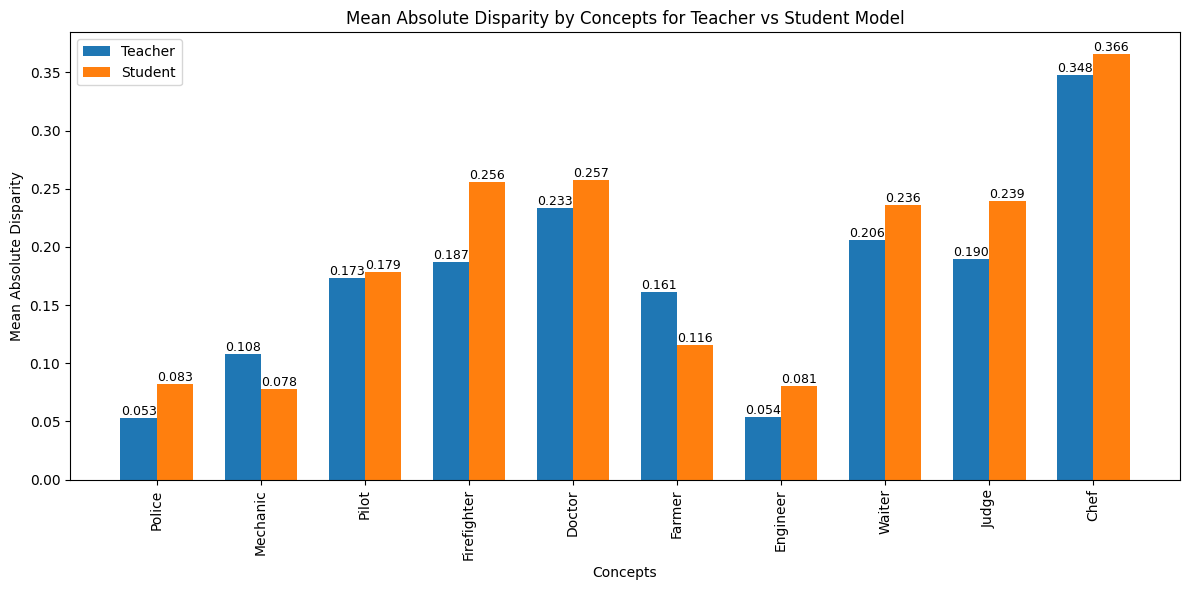

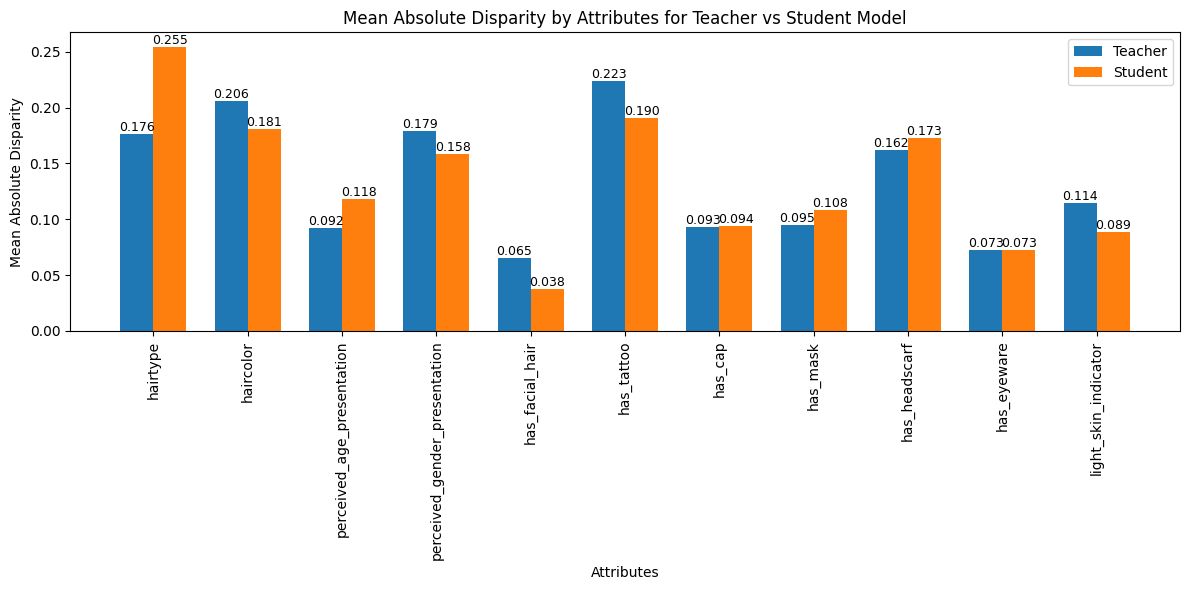

In [31]:
def plot_disparities(data_dict_student, data_dict_teacher, label_type):
    """
    Plots the mean absolute disparity bars for Teacher vs Student Models for either concepts or attributes.
    
    Args:
    - data_dict_student (dict): Dictionary of disparities for the student model.
    - data_dict_teacher (dict): Dictionary of disparities for the teacher model.
    - label_type (str): A descriptor ("Concepts" or "Attributes") to indicate what type of data is being plotted.
    """
    
    # Extracting disparities
    labels = list(data_dict_student.keys())
    student_disparities = list(data_dict_student.values())
    teacher_disparities = list(data_dict_teacher.values())

    # Setting up bar positions and width
    bar_width = 0.35
    index = np.arange(len(labels))

    # Plotting the data
    plt.figure(figsize=(12,6))
    bar1 = plt.bar(index, teacher_disparities, bar_width, label='Teacher', color='#1f77b4')  # Teacher is blue
    bar2 = plt.bar(index + bar_width, student_disparities, bar_width, label='Student', color='#ff7f0e')  # Student is orange

    # Adding data label values on top of each bar
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, '%.3f' % height, ha='center', va='bottom', fontsize=9)

    add_labels(bar1)
    add_labels(bar2)

    # Labeling the chart
    plt.xlabel(label_type)
    plt.ylabel('Mean Absolute Disparity')
    plt.title(f'Mean Absolute Disparity by {label_type} for Teacher vs Student Model')
    plt.xticks(index + bar_width / 2, labels, rotation=90)
    plt.legend()

    # Displaying the plot
    plt.tight_layout()
    plt.show()

# Now call the function for both concepts and attributes
plot_disparities(student_concept_disparity_dict, teacher_concept_disparity_dict, 'Concepts')
plot_disparities(student_attribute_disparity_dict, teacher_attribute_disparity_dict, 'Attributes')


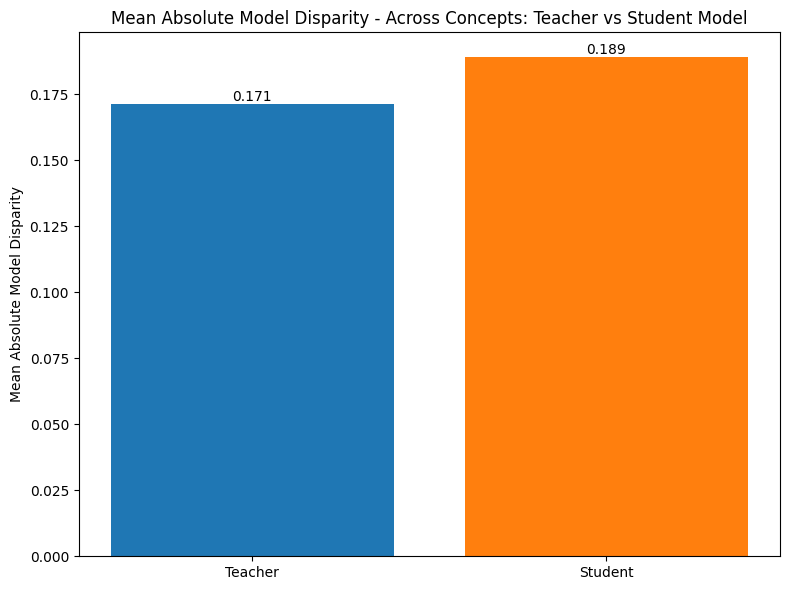

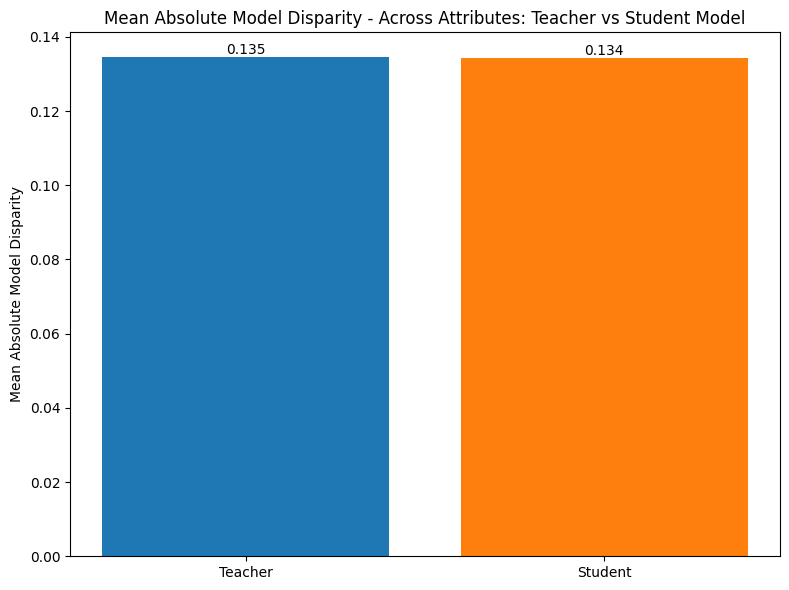

In [32]:
def plot_mean_absolute_disparity(disparities, descriptor):
    """
    Plots the mean absolute disparity for Teacher vs Student Models.
    
    Args:
    - disparities (list): List containing disparities for teacher and student.
    - descriptor (str): String describing the kind of disparities (e.g., "Across Concepts" or "Across Attributes").
    """
    
    # Data
    labels = ["Teacher", "Student"]
    colors = ['#1f77b4', '#ff7f0e']

    # Setting up the plot
    plt.figure(figsize=(8,6))

    # Creating bars
    bars = plt.bar(labels, disparities, color=colors)

    # Adding data label values on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.3f' % height, ha='center', va='bottom', fontsize=10)

    # Labeling the plot
    plt.ylabel('Mean Absolute Model Disparity')
    plt.title(f'Mean Absolute Model Disparity - {descriptor}: Teacher vs Student Model')
    plt.tight_layout()
    plt.show()

# Now call the function for both concepts and attributes
plot_mean_absolute_disparity([teacher_mean_disparity_overall_concept, student_mean_disparity_overall_concept], "Across Concepts")
plot_mean_absolute_disparity([teacher_mean_disparity_overall_attribute, student_mean_disparity_overall_attribute], "Across Attributes")


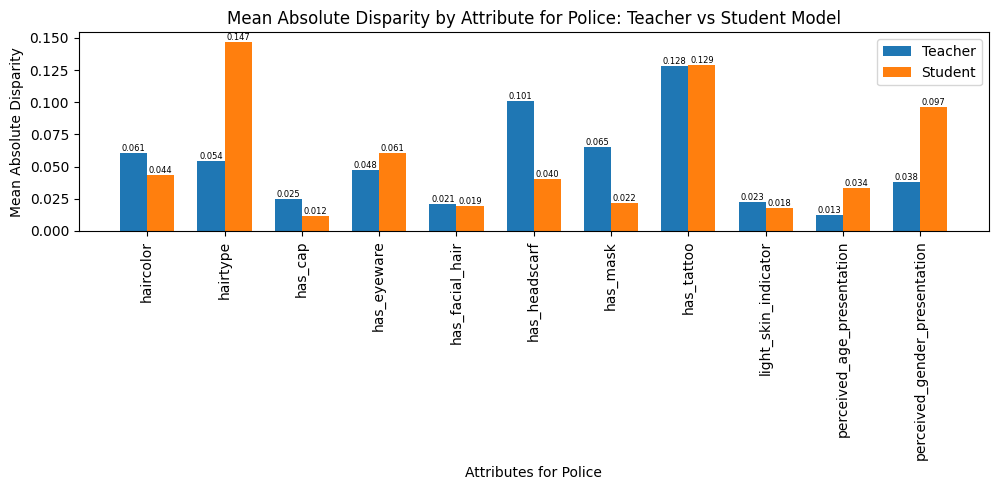

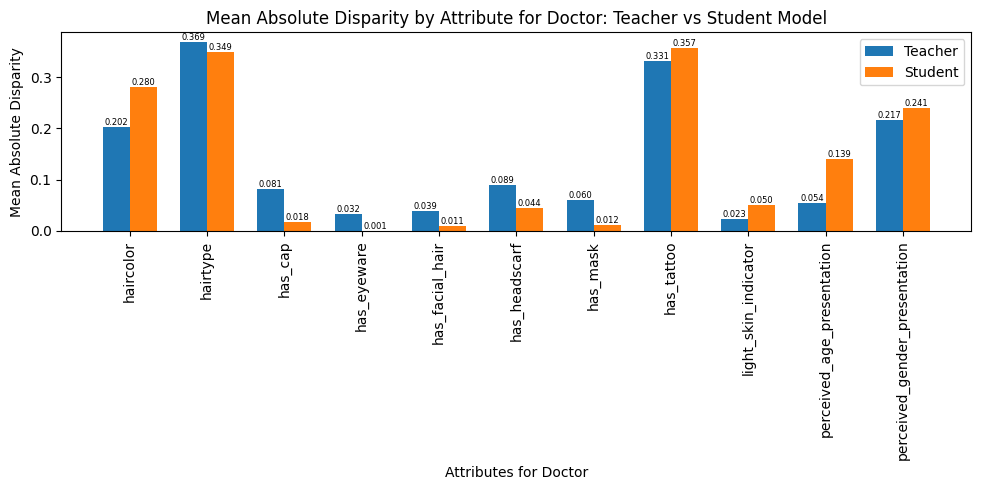

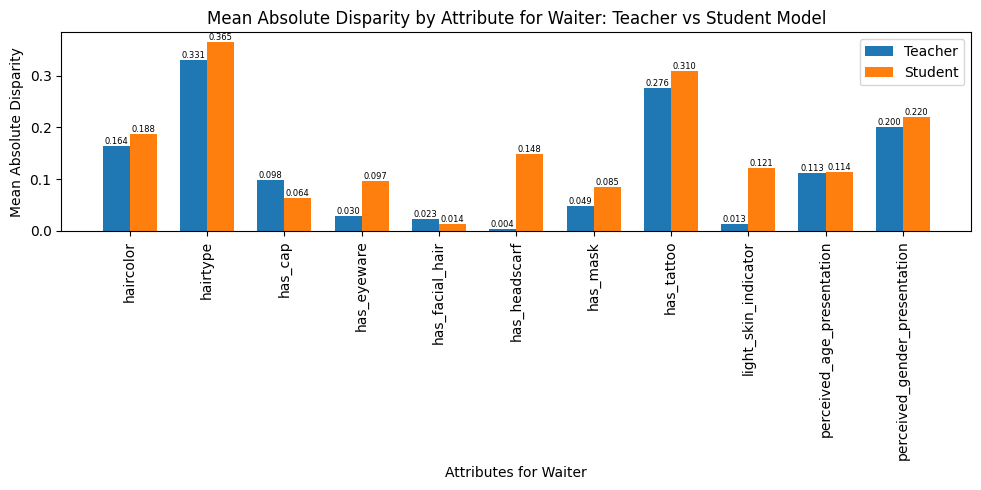

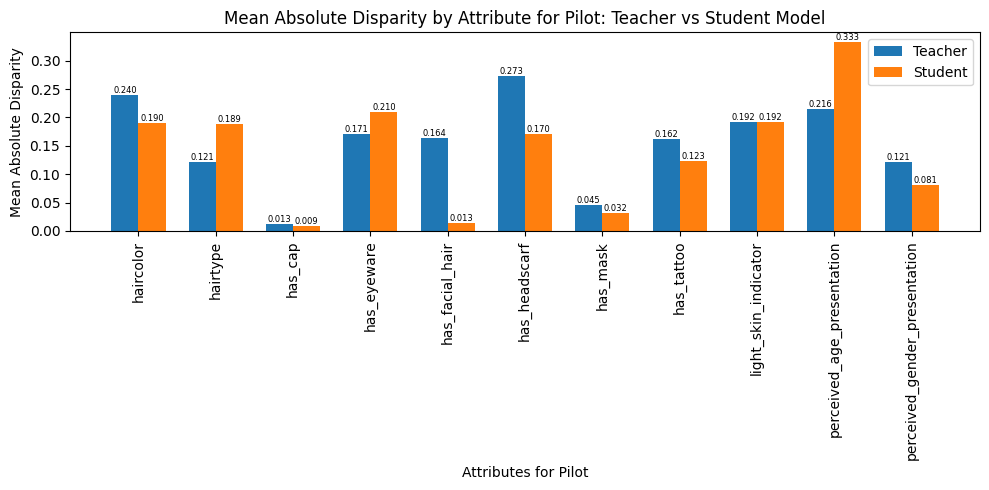

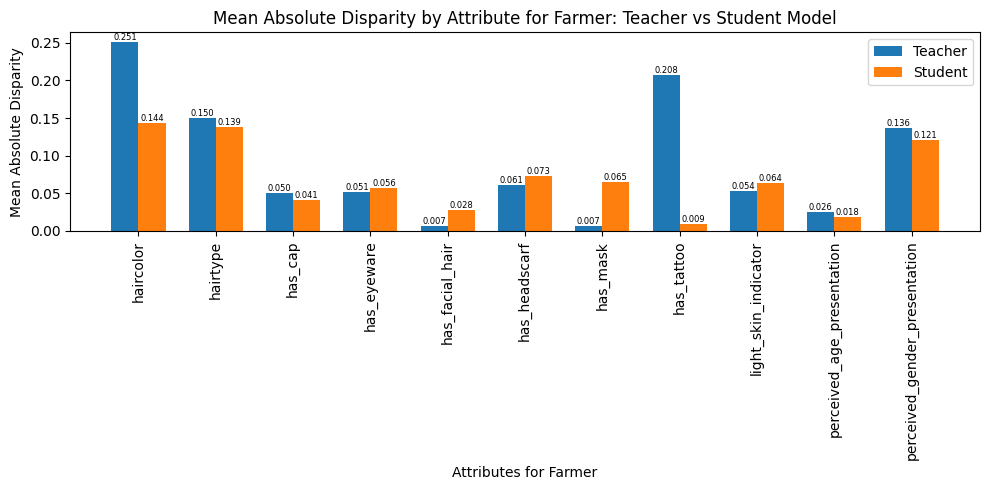

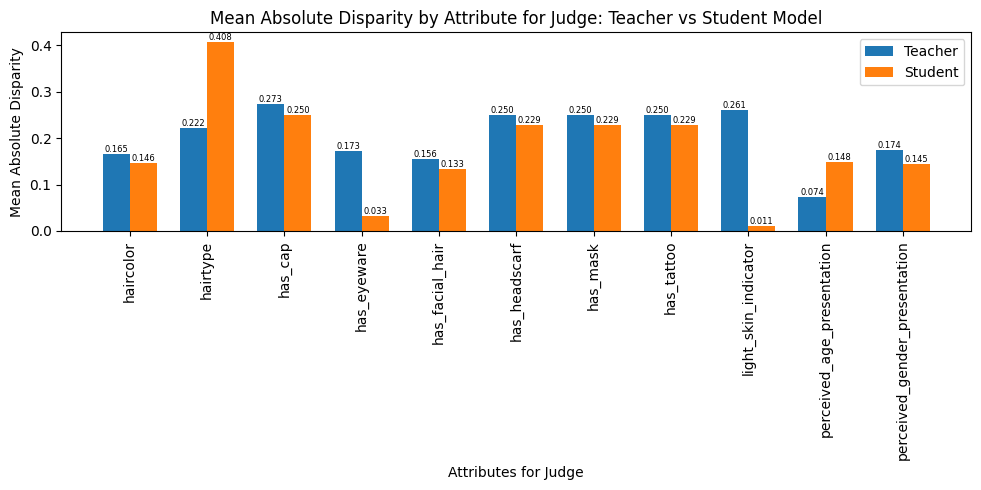

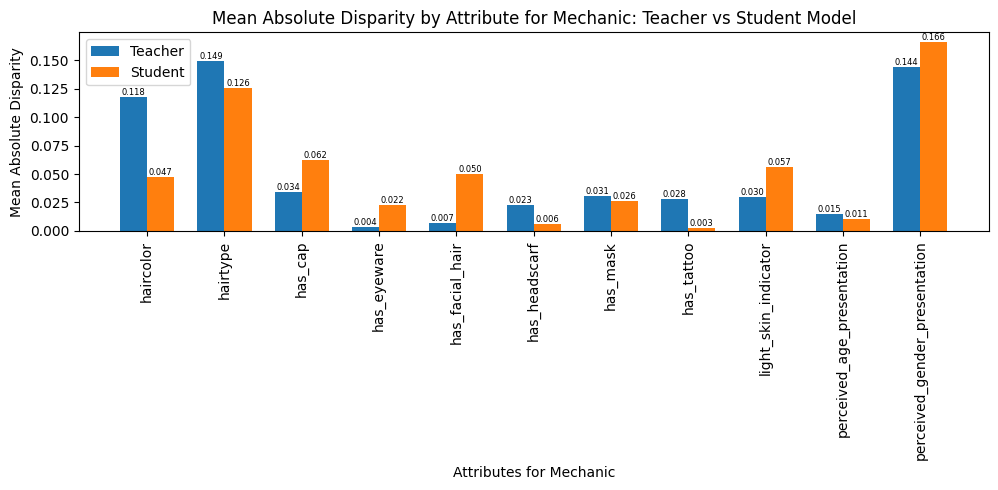

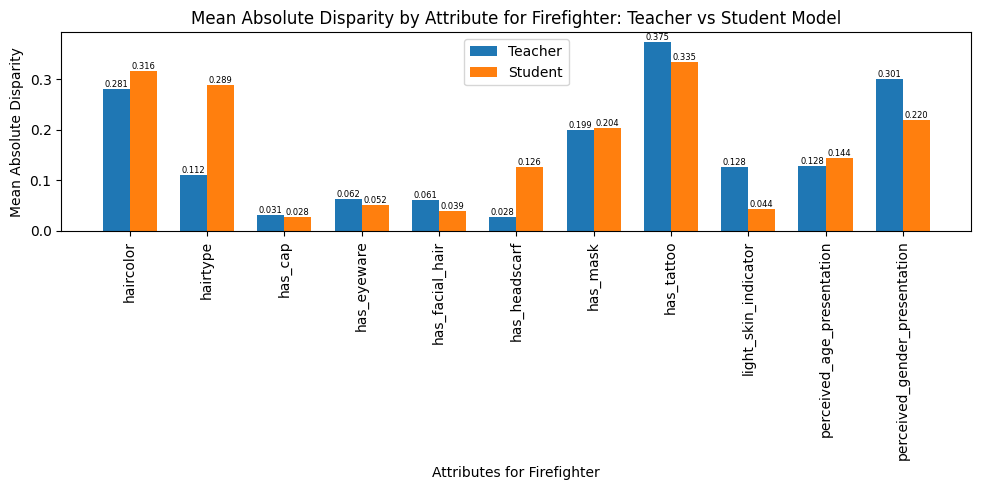

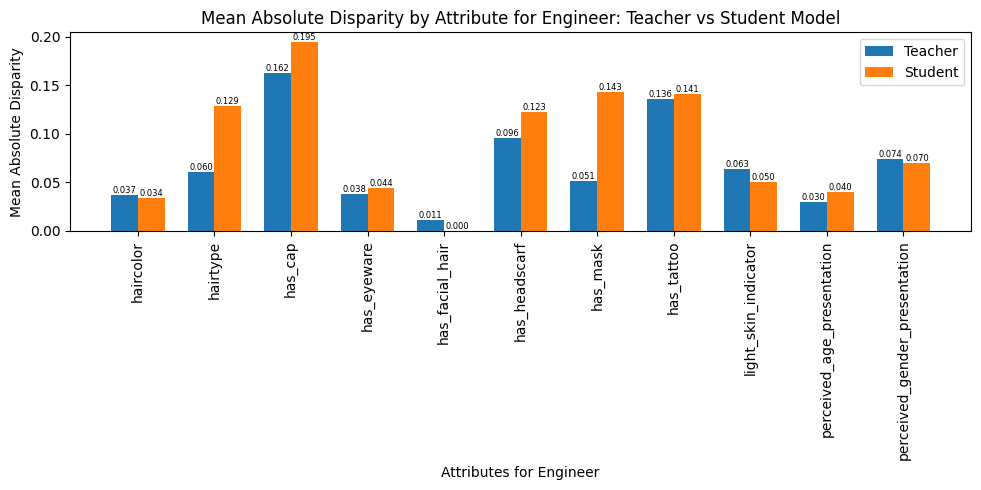

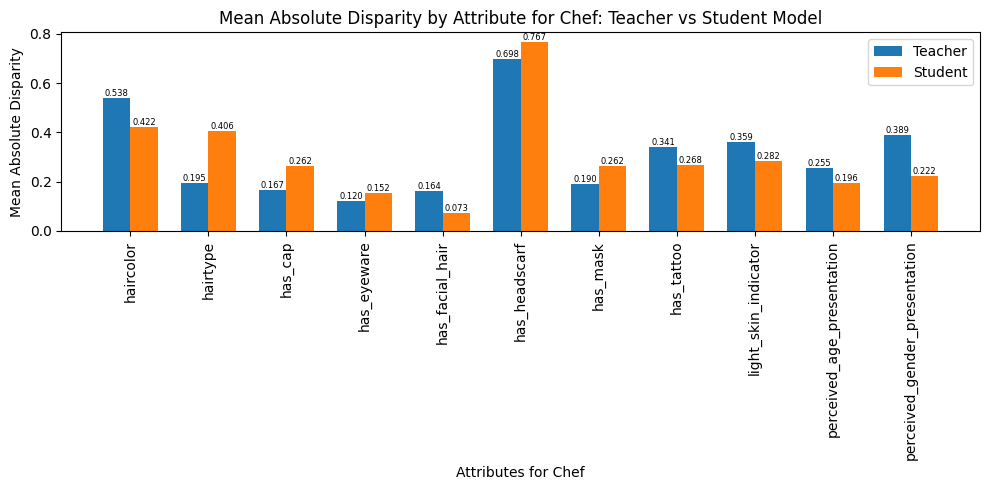

In [41]:
# Extract unique concepts and attribute-concept pairs for sorting
unique_concepts = set(pair[0] for pair in student_disparity_dict.keys())
sorted_pairs = sorted(student_disparity_dict.keys(), key=lambda x: (x[0], x[1]))


# Function to plot disparities for a given concept
def plot_disparities_for_concept(concept):
    # Filter out disparities for the given concept
    relevant_pairs = [pair for pair in sorted_pairs if pair[0] == concept]
    relevant_student_disparities = [student_disparity_dict[pair] for pair in relevant_pairs]
    relevant_teacher_disparities = [teacher_disparity_dict[pair] for pair in relevant_pairs]

    # Setting up the plot
    plt.figure(figsize=(10,5))

    # Setting bar width and positions
    bar_width = 0.35
    index = np.arange(len(relevant_pairs))

    # Creating bars
    bar1 = plt.bar(index, relevant_teacher_disparities, bar_width, label='Teacher')
    bar2 = plt.bar(index + bar_width, relevant_student_disparities, bar_width, label='Student')

    # Adding data label values on top of each bar
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, '%.3f' % height, ha='center', va='bottom', fontsize=6)

    add_labels(bar1)
    add_labels(bar2)

    # Labeling the plot
    plt.xlabel('Attributes for ' + concept)
    plt.ylabel('Mean Absolute Disparity')
    plt.title(f'Mean Absolute Disparity by Attribute for {concept}: Teacher vs Student Model')

    # Setting x-axis labels to be attributes for the current concept
    labels = [pair[1] for pair in relevant_pairs]
    plt.xticks(index + bar_width / 2, labels, rotation=90)

    # Displaying the legend and the plot
    plt.legend()
    plt.tight_layout()
    plt.show()

# Loop through each unique concept and plot disparities for that concept
for concept in unique_concepts:
    plot_disparities_for_concept(concept)
